In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

# Альтернативные способы обучения

Стандартное обучение исходной модели (например, метод наименьших квадратов в линейной регрессии) может создавать описанные выше проблемы. Чтобы уменьшить вероятность их возникновения, применяют альтернативные способы обучения, такие как:
* обучение с выбором подмножества фич (subset selection)
* обучение с регуляризаций (shrinkage или regularization)
* обучение с уменьшением размерности фич (dimensionality reduction)

## Subset selection

Идея проста:
* создать множество моделей-кандидатов, содержащих только часть фич
* выбрать лучшего кандидата, оценив тестовую ошибку

### Best subset selection

```python
candidates = [M0]
for k in range(1, p + 1):
    pre_candidates = get_fit_models(n_features=k)  # все комбинации из p по k
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

### Stepwise selection

Best subset selection очень дорог, хотя и гарантирует нахождение оптимального решения. Более того, чем больше $p$, тем больше вероятность найти модели, которые показывают отличные результаты на тренировочных данных и плохие на тестовых. Поэтому мы хотим сузить область поиска кандидатов.

#### Forward stepwise selection

```python
candidates = [M0]
for k in range(0, p):
    # находим модели, дополняющие предыдущую модель одной фичей
    pre_candidates = get_models_with_one_additional_feature(candidates[-1])
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

#### Backward stepwise selection

```python
candidates = [Mp]
for k in range(p, 0, -1):
    # находим модели без одной из фич, присутствующих в candidates[-1]
    pre_candidates = get_models_without_one_feature(candidates[-1])
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

### Выбор лучшего кандидата

* косвенная оценка: оцениваем модели на тренировочных данных, корректируя тренировочную ошибку
* непосредственная оценка: оцениваем модели на validation set
    
Косвенную оценку используют, когда очень дорого делать cross-validation. 

 

## Shrinkage (регуляризация)

#### Линейная регрессия
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2$$
#### Ridge
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2 + \lambda \sum_{j=1}^p \beta_j^2$$
#### Lasso
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2 + \lambda \sum_{j=1}^p |\beta_j|$$

In [2]:
adv_df = pd.read_csv('Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
adv_df.shape

(200, 4)

In [4]:
X = adv_df[["TV", "radio", "newspaper"]].values
y = adv_df.sales

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [6]:
lm = LinearRegression().fit(X, y) # обычная линейная регрессия
print(lm.intercept_)
print(lm.coef_)

2.9388893694594085
[ 0.04576465  0.18853002 -0.00103749]


In [7]:
rg = Ridge().fit(X, y) # Эта модель решает регрессионную модель, где функция потерь является
                       # линейной функцией наименьших квадратов, а регуляризация задается l2
print(rg.intercept_)
print(rg.coef_)

2.9389674583301524
[ 0.04576464  0.1885251  -0.00103629]


In [8]:
rg = Lasso().fit(X, y)  # Регрессионная модель,с регуляризацией l1
print(rg.intercept_)
print(rg.coef_)

3.0402155834803786
[0.04566142 0.1834644  0.        ]


In [9]:
rg.coef_ - lm.coef_

array([-0.00010323, -0.00506562,  0.00103749])

## Dimensionality reduction

Трансформирует $p$ фич в $M$ линейных комбинаций этих фич, так, что $M < p$. Новые фичи ($Z_i$) используются для построения модели. Основная идея при трансформации - объяснить новыми фичами как можно больший процент вариативности (variance) исходных данных, при этом уменьшив размерность пространства.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1]).fit(X)
for i in range(1, X.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.914
n-components=2, explained variance 0.978
n-components=3, explained variance 1.000


In [11]:
new_adv_df = pd.DataFrame(PCA(n_components=1).fit_transform(X), columns=["f1"])

new_adv_df["Sales"] = adv_df.sales
new_adv_df.head(5)

,f1,Sales
0,83.788546,22.1
1,-102.138730,10.4
2,-128.992484,9.3
3,5.070972,18.5
4,34.059003,12.9


In [12]:
new_adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      200 non-null    float64
 1   Sales   200 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


#### Полное пространство

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [16]:
%%time
regr = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
regr.fit(X_train, y_train)

Wall time: 98.7 ms


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [17]:
y_predict_rf= regr.predict(X_test)

In [18]:
print('MSE = ',mean_squared_error(y_test, y_predict_rf))
print('Ср.абс.ош. = ',mean_absolute_error(y_test, y_predict_rf))

MSE =  0.7498715469653419
Ср.абс.ош. =  0.6841936930084238


#### Сжатое пространство

In [19]:
X = adv_df[["TV", "radio", "newspaper"]].values
y = adv_df.sales

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)

In [21]:
X_train_f1, X_test_f1, y_train_f1, y_test_f1 = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [22]:
%%time
regr_f1 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
regr_f1.fit(X_train_f1, y_train_f1)

Wall time: 93.7 ms


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [23]:
y_predict_rf_f1= regr_f1.predict(X_test_f1)

In [24]:
print('MSE = ',mean_squared_error(y_test_f1, y_predict_rf_f1))
print('Ср.абс.ош. = ',mean_absolute_error(y_test_f1, y_predict_rf_f1))

MSE =  10.221520154519094
Ср.абс.ош. =  2.48542272301512


### PCA

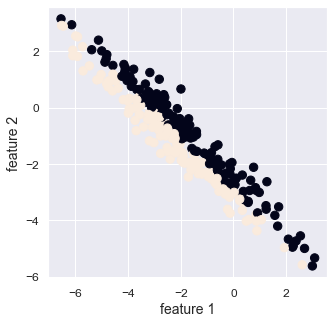

In [25]:
plt.rcParams['figure.figsize'] = 5, 5

rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2)
y = X_[:, 0] > 0

plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y, s=70) # , linewidths=0
plt.xlabel("feature 1")
plt.ylabel("feature 2");


In [26]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_blob)
X_pca = pca.transform(X_blob)

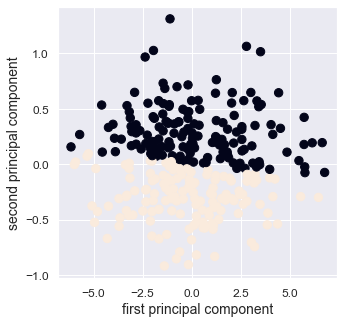

In [27]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=70) # linewidths=1, 
plt.xlabel("first principal component")
plt.ylabel("second principal component");

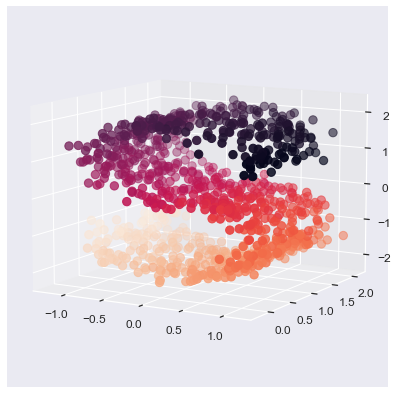

In [28]:

plt.rcParams['figure.figsize'] = 7, 7

from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=1000, noise=0.1)

from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=70)
ax.view_init(10, -60)

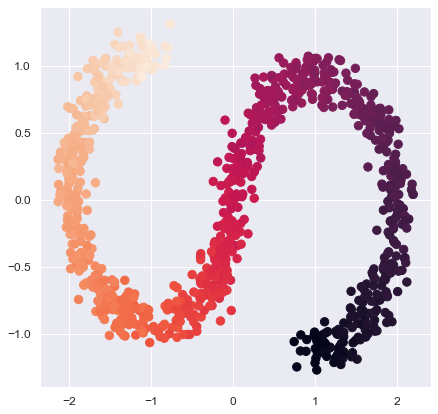

In [29]:
X_pca = PCA(n_components=2).fit_transform(X) # метод главных компонент
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=70);

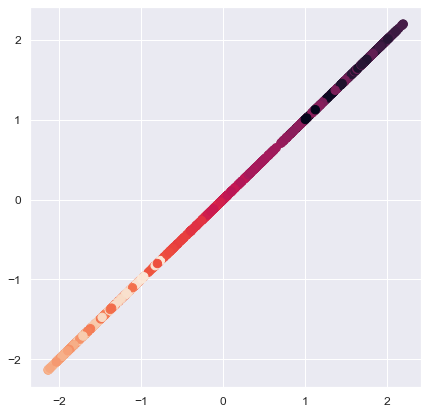

In [30]:
X_pca = PCA(n_components=1).fit_transform(X) # метод главных компонент
plt.scatter(X_pca[:,0], X_pca[:,0], c=y, s=70);

In [31]:
from sklearn.manifold import Isomap

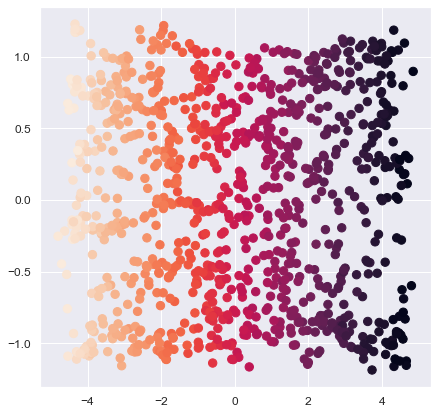

In [32]:
iso = Isomap(n_neighbors=15, n_components=2) # Уменьшение нелинейной размерности с помощью изометрии
X_iso = iso.fit_transform(X)
plt.scatter(X_iso[:,0], X_iso[:,1], c=y, s=70);